# Fallback Table Metalearning ASSIGNMENT


In [1]:
options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)

In [2]:
# install.packages("pkgcond")

In [3]:
library(dplyr)
library(data.table)
library(partykit)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)
library(dominanceanalysis)


getwd()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: lattice

Loading required package: ggplot2

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘ranger’


The following object is masked from ‘package:randomForest’:

    importance



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:sta

[1] "/home/jupyter/Domains_202003/scripts/phaseII_06_fallbacksupp"

In [4]:

source('../orig/functions.R')

source('../orig/functions_models.R')

source('../phaseII_03_forest/functions_eval.R')



Attaching package: ‘tidyr’


The following object is masked from ‘package:stringdist’:

    extract




In [5]:
source('functions_metalearning.R')

In [6]:
source('functions_fallback.R')

In [22]:
# source('load_prep_data_expiry_2.R') #read in train test and predictions manually instead

# READ CSV's
expiry_df_test_preds <- read.csv("../../data/output/datapull_20201116/expiry_df_test_preds_fb.csv")
expiry_df_train <- read.csv("../../data/output/datapull_20201116/expiry_df_train.csv")
# expiry_df_test <- read.csv("../../data/output/datapull_20201116/expiry_df_test.csv")
metametrics_df <- read.csv("../../data/output/datapull_20201116/expiry_metametrics_df.csv")
# expiry_df
# expiry_train_df 
# expiry_test_df 
# expiry_list
# expiry_train_list
# expiry_test_list

# Chosen models and metrics:

3 models: agg_rf_ALL, seg2_glm and seg_glm_fb
metric: l10 lift
model: random forest rebalanced

# PREP data

## Add win flags

In [8]:
(auc_vars = c('auc_seg2_glm','auc_agg_rf_ALL','auc_seg2_glm_fb'))
(l10_vars = c('l10_seg2_glm','l10_agg_rf_ALL','l10_seg2_glm_fb'))

metametrics_df <- metametrics_df %>%
    mutate (auc_win_04=sapply(apply(.[,c(auc_vars)], 
                          1, function(x) names(x)[which.max(x)]) , function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) ,
            l10_win_04=sapply(apply(.[,c(l10_vars)], 
                          1, function(x) names(x)[which.max(x)]), function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) 
            ) 

[1] "auc_seg2_glm"    "auc_agg_rf_ALL"  "auc_seg2_glm_fb"

[1] "l10_seg2_glm"    "l10_agg_rf_ALL"  "l10_seg2_glm_fb"

In [9]:
as.data.frame(sort(table(metametrics_df$auc_win_04), decreasing=TRUE))
as.data.frame(sort(table(metametrics_df$l10_win_04), decreasing=TRUE))
as.data.frame(sort(prop.table(table(metametrics_df$auc_win_04)), decreasing=TRUE))
as.data.frame(sort(prop.table(table(metametrics_df$l10_win_04)), decreasing=TRUE))

Var1,Freq
<fct>,<int>
auc_seg2_glm,715
auc_agg_rf_ALL,609
auc_seg2_glm_fb,158


Var1,Freq
<fct>,<int>
l10_seg2_glm,939
l10_agg_rf_ALL,457
l10_seg2_glm_fb,86


Var1,Freq
<fct>,<dbl>
auc_seg2_glm,0.4824561
auc_agg_rf_ALL,0.4109312
auc_seg2_glm_fb,0.1066127


Var1,Freq
<fct>,<dbl>
l10_seg2_glm,0.63360324
l10_agg_rf_ALL,0.30836707
l10_seg2_glm_fb,0.05802969


## missing value imputation

In [10]:
# install.packages("missRanger")
library(missRanger)

In [11]:
metametrics_imp_df <- missRanger(metametrics_df, num.trees = 100)


Missing value imputation by random forests

  Variables to impute:		geo_maj, daydom_std, daydom_skew, daydom_kurt, sldlen_std, sldlen_skew, sldlen_kurt, gibbs_std, gibbs_skew, gibbs_kurt, pdcnt_std, pdcnt_skew, pdcnt_kurt, regarpt_std, regarpt_skew, regarpt_kurt, l10_seg2_glm, l10_seg_glm, l10_agg_glm_ALL, l10_agg_glm, l10_seg2_rf, l10_seg_rf, l10_agg_rf, l10_agg_rf_ALL, auc_seg2_glm, auc_seg_glm, auc_agg_glm_ALL, auc_agg_glm, auc_seg2_rf, auc_seg_rf, auc_agg_rf_ALL, auc_agg_rf, l10_seg2_glm_fb, l10_seg_glm_fb, l10_agg_glm_fb, l10_agg_glm_ALL_fb, l10_seg2_rf_fb, l10_seg_rf_fb, l10_agg_rf_fb, l10_agg_rf_ALL_fb, auc_seg2_glm_fb, auc_seg_glm_fb, auc_agg_glm_fb, auc_agg_glm_ALL_fb, auc_seg2_rf_fb, auc_seg_rf_fb, auc_agg_rf_fb, auc_agg_rf_ALL_fb, auc_win_04, l10_win_04
  Variables used to impute:	tld_registrar_index, geo_maj, geo_cnt, n, ren_prp, tld_cnt, tld_rat, daydom_min, daydom_max, daydom_mean, daydom_rng, daydom_std, daydom_skew, daydom_kurt, sldlen_min, sldlen_max, sldlen_mean, sld

## train/test split

In [12]:
set.seed(123) 
smp_siz = floor(0.8*nrow(metametrics_imp_df))
train_ind = sample(seq_len(nrow(metametrics_imp_df)),size = smp_siz) 
train = metametrics_imp_df[train_ind,] 
test = metametrics_imp_df[-train_ind,]  

In [13]:
dim(train)
dim(test)

[1] 1406   80

[1] 352  80

# Train Models & Obtain Predictions

In [14]:
#Compute weights to balance the RF
Y = train$l10_win_04
w <- 1/table(Y)
w <- w/sum(w)

weights <- rep(0, length(Y))

for (model in unique(Y)){
    weights[Y==model] <- w[model]
}
table(round(weights,2), Y)

      Y
       l10_agg_rf_ALL l10_seg2_glm l10_seg2_glm_fb
  0.06              0          959               0
  0.14            381            0               0
  0.81              0            0              66

In [15]:
# l10
model_l10 <- ranger(formula         = l10_win_04 ~ ., 
                data            = train %>% 
                                    select('l10_win_04') %>% 
                                    bind_cols(
                                        train %>% 
                                        select(-contains('auc'),-contains('l10'),-'tld_registrar_index', -'tld_rat')), 
                importance = 'impurity', 
                num.trees       = 500,
                probability = TRUE,
                replace = FALSE,
                sample.fraction = .8,
                seed            = 123,
                respect.unordered.factors=TRUE,
               case.weights=weights)

pred_l10 <- as.data.frame(predict(model_l10, 
                data = test,
                type="response")$predictions) %>%
    mutate (l10_win_04_pred_model=sapply(apply(., 
                          1, function(x) names(x)[which.max(x)]) , 
                                    function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) 
            ) 
                                        
# auc
model_auc <- ranger(formula         = auc_win_04 ~ ., 
                data            = train %>% 
                                    select('auc_win_04') %>% 
                                    bind_cols(
                                        train %>% 
                                        select(-contains('auc'),-contains('l10'),-'tld_registrar_index', -'tld_rat')), 
                importance = 'impurity', 
                num.trees       = 500,
                probability = TRUE,
                replace = FALSE,
                sample.fraction = .8,
                seed            = 123,
                respect.unordered.factors=TRUE,
               case.weights=weights)

pred_auc <- as.data.frame(predict(model_auc, 
                data = test,
                type="response")$predictions) %>%
                                               
    mutate (auc_win_04_pred_model=sapply(apply(., 
                          1, function(x) names(x)[which.max(x)]) , 
                                    function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) 
            ) 
                                        

In [17]:
test_pred <- cbind(test,pred_l10$l10_win_04_pred_model,pred_auc$auc_win_04_pred_model)
# test_pred <- test_pred %>% select()
dim(pred_l10)
dim(pred_auc)
dim(test_pred)
dim(test_pred)
head(test_pred)
# 04.1 is the prediction result

[1] 352   4

[1] 352   4

[1] 352  82

[1] 352  82

,tld_registrar_index,geo_maj,geo_cnt,n,ren_prp,tld_cnt,tld_rat,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,⋯,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf_ALL,auc_agg_rf,l10_seg2_glm_fb,l10_seg_glm_fb,l10_agg_glm_fb,l10_agg_glm_ALL_fb,l10_seg2_rf_fb,l10_seg_rf_fb,l10_agg_rf_fb,l10_agg_rf_ALL_fb,auc_seg2_glm_fb,auc_seg_glm_fb,auc_agg_glm_fb,auc_agg_glm_ALL_fb,auc_seg2_rf_fb,auc_seg_rf_fb,auc_agg_rf_fb,auc_agg_rf_ALL_fb,auc_win_04,l10_win_04,pred_l10$l10_win_04_pred_model,pred_auc$auc_win_04_pred_model
,<fct>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
3,fun1api,EU,1,8,0.50000000,1,0.125000000,1,1,1.000000,0,0.0000000,1.5658080,1.1564401,4,15,8.875000,11,3.5228844,0.4848693,-1.143452,2.00,6.09,4.396250,4.09,⋯,0.4250000,0.3500000,0.4750000,0.3500000,0.5500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,auc_seg2_glm_fb,l10_seg2_glm_fb,l10_seg2_glm,auc_seg2_glm
7,funalibaba sg,China,1,195,0.04102564,1,0.005128205,1,490,296.728205,489,228.3117623,-0.3415584,-1.8644672,4,15,6.794872,11,2.3106598,1.4636429,1.315210,0.12,16.72,4.425128,16.60,⋯,0.8625000,0.8875000,0.8750000,0.8750000,0.8750000,7.500000,5.000000,6.250000,6.250000,3.750000,2.500000,3.750000,3.750000,0.9250000,0.9000000,0.8625000,0.8500000,0.8875000,0.8750000,0.8750000,0.8750000,auc_seg2_glm,l10_seg2_glm,l10_agg_rf_ALL,auc_agg_rf_ALL
15,funcafe24,"Vietnam, Korea & Indonesia",1,3,0.00000000,1,0.333333333,1,2,1.333333,1,0.5773503,0.3849002,-2.3333333,5,6,5.666667,1,0.5773503,-0.3849002,-2.333333,0.48,5.80,2.926667,5.32,⋯,0.6000376,0.6546695,0.6871427,0.6360214,0.5983887,4.269437,4.363352,4.031874,4.008743,4.829749,4.852859,4.669066,4.758851,0.6076759,0.6139171,0.6158047,0.5954856,0.6227286,0.6291192,0.6194290,0.6157651,auc_seg2_glm,l10_seg2_glm,l10_seg2_glm,auc_seg2_glm
21,funcronon ag,EU,1,10,0.70000000,1,0.100000000,1,3,1.400000,2,0.6992059,1.1935618,-0.0746281,3,24,11.400000,21,7.3966960,0.7355118,-1.053701,1.05,100.00,13.731000,98.95,⋯,0.6500000,0.6500000,0.6500000,0.6500000,0.5785714,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,0.5071429,0.5071429,0.5071429,0.5071429,0.5071429,0.5071429,0.5071429,0.5071429,auc_seg2_glm,l10_seg2_glm,l10_seg2_glm,auc_agg_rf_ALL
22,funcsc corporate,United States,1,3,1.00000000,1,0.333333333,1,4,3.000000,3,1.7320508,-0.3849002,-2.3333333,11,16,14.000000,5,2.6457513,-0.3239695,-2.333333,4.71,6.28,5.233333,1.57,⋯,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,auc_seg2_glm,l10_seg2_glm,l10_seg2_glm,auc_seg2_glm
43,funglobal domains,United States,1,271,0.00000000,1,0.003690037,1,71,32.129151,70,20.7593334,0.4921998,-0.8367946,4,23,11.025830,19,3.6223684,1.0939010,1.296427,0.52,12.22,5.511661,11.70,⋯,0.6808176,0.8503536,0.8506547,0.8514446,0.8429044,4.789892,4.669712,3.382280,3.507468,5.424845,5.820438,5.325877,5.228621,0.7781662,0.7643041,0.6961987,0.7015210,0.8323627,0.8491662,0.8370442,0.8319197,auc_agg_rf_ALL,l10_agg_rf_ALL,l10_agg_rf_ALL,auc_agg_rf_ALL


# Assign model based on preds

In [23]:
# load preds,
# expiry_df_test_preds <- read.csv("../../data/output/datapull_20201116/expiry_df_test_preds_fb.csv")

# generate lookup, use last column which contains predictions

# merge with lookup, only include those tld-re's for which predictions exist
expiry_df_test_preds_assign <- merge(expiry_df_test_preds, 
                                     test_pred %>% select(tld_registrar_index, length(test_pred)-1, length(test_pred)), 
                                     by="tld_registrar_index", all.y=TRUE) 
expiry_df_test_preds_assign <- expiry_df_test_preds_assign %>% 
                                rename(l10_win_04_pred_model = length(expiry_df_test_preds_assign)-1,
                                      auc_win_04_pred_model = length(expiry_df_test_preds_assign))
dim(expiry_df_test_preds)
dim(expiry_df_test_preds_assign)
head(expiry_df_test_preds_assign)

[1] 932347     59

[1] 99187    61

,tld_registrar_index,reseller,reseller_country,domain_id,renewal_type,renewed_count,expiry_date,creation_date,status,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,⋯,pred_seg_glm_ALL,pred_seg_rf_ALL,pred_seg2_glm_ALL,pred_seg2_rf_ALL,reseller_geo,pred_agg_glm_ALL_fb,pred_agg_rf_ALL_fb,pred_agg_glm_fb,pred_agg_rf_fb,pred_seg_glm_ALL_fb,pred_seg_rf_ALL_fb,pred_seg2_glm_ALL_fb,pred_seg2_rf_ALL_fb,reg_arpt_org,reg_arpt_slab,pred_seg2_rf_ALL_fb2,pred_seg2_glm_ALL_fb2,pred_seg_rf_ALL_fb2,pred_seg_glm_ALL_fb2,pred_agg_rf_fb2,pred_agg_glm_fb2,pred_agg_rf_ALL_fb2,pred_agg_glm_ALL_fb2,l10_win_04_pred_model,auc_win_04_pred_model
,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,fun1api,1API,Germany,77112544,FirstTime,1,2019-09-21,2018-09-21,Active,alparty.fun,1API,NA,1,3,3,0,233136706,auto-renewal,unrealized,Not Renewd,2019-09-21,15,3.58,alparty,1,⋯,0.417,0.5922474,0.4780584,0.6233142,EU,NA,NA,NA,NA,NA,NA,NA,NA,3,"(1,3]",0.211,0.211,0.211,0.211,0.211,0.211,0.211,0.211,l10_seg2_glm,auc_seg2_glm
2,fun1api,1API,Germany,118771316,FirstTime,1,2020-08-20,2019-08-20,Active,echt-geil.fun,1API,NA,1,5,5,0,329057769,renewal,NA,Renewed,2020-07-13,15,2.00,echt-geil,1,⋯,0.362,0.6854120,NA,0.4911790,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm
3,fun1api,1API,Germany,101717674,FirstTime,1,2020-04-24,2019-04-24,Active,gotsome.fun,1API,NA,1,5,5,0,310645094,auto-renewal,unrealized,Not Renewd,2020-04-24,15,6.09,gotsome,1,⋯,0.536,0.6623480,0.6194136,0.6294112,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm
4,fun1api,1API,Germany,89153032,FirstTime,1,2019-12-29,2018-12-29,Active,noor.fun,1API,NA,1,3,3,0,263535836,renewal,NA,Renewed,2019-12-08,15,5.77,noor,1,⋯,0.450,0.5021543,0.4426250,0.3342575,EU,NA,NA,NA,NA,NA,NA,NA,NA,3,"(1,3]",0.211,0.211,0.211,0.211,0.211,0.211,0.211,0.211,l10_seg2_glm,auc_seg2_glm
5,fun1api,1API,Germany,118627451,FirstTime,1,2020-08-19,2019-08-19,Active,laurendoesstuff.fun,1API,NA,1,5,5,0,338522944,auto-renewal,unrealized,Not Renewd,2020-08-19,15,4.83,laurendoesstuff,1,⋯,0.458,0.4730591,0.7268515,0.6059519,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm
6,fun1api,1API,Germany,93057463,FirstTime,1,2020-02-07,2019-02-07,Active,bottegaveneta.fun,1API,NA,1,5,5,0,289674366,auto-renewal,realized,Renewed,2020-02-07,15,5.21,bottegaveneta,1,⋯,0.478,0.5808743,0.7021113,0.6055075,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm


## assign prediction based on prediction results

In [24]:
# 04.1 is the prediction result
expiry_df_test_preds_assign <- expiry_df_test_preds_assign %>%
  mutate(
  l10_win_04_pred_value = (l10_win_04_pred_model=='l10_seg2_glm_fb')*pred_seg2_glm_ALL_fb2+
                          (l10_win_04_pred_model=='l10_agg_rf_ALL')*pred_agg_rf_ALL+
                          (l10_win_04_pred_model=='l10_seg2_glm')*pred_seg2_glm_ALL,

  auc_win_04_pred_value = (auc_win_04_pred_model=='auc_seg2_glm_fb')*pred_seg2_glm_ALL_fb2+
                          (auc_win_04_pred_model=='auc_agg_rf_ALL')*pred_agg_rf_ALL+
                          (auc_win_04_pred_model=='auc_seg2_glm')*pred_seg2_glm_ALL)

# $l10_win_04_pred_value <- 
# (expiry_df_test_preds_assign$l10_win_04_pred_model=='l10_seg2_glm_fb')*expiry_df_test_preds_assign$pred_seg2_glm_fb+
# (expiry_df_test_preds_assign$l10_win_04_pred_model=='l10_agg_rf_ALL')*expiry_df_test_preds_assign$pred_agg_rf_ALL+
# (expiry_df_test_preds_assign$l10_win_04_pred_model=='l10_seg2_glm')*expiry_df_test_preds_assign$pred_seg2_glm+

head(expiry_df_test_preds_assign %>% select(l10_win_04_pred_model, l10_win_04_pred_value, 
                                            auc_win_04_pred_model, auc_win_04_pred_value,
                                               pred_seg2_glm_ALL_fb2,pred_agg_rf_ALL, pred_seg2_glm_ALL),10)

,l10_win_04_pred_model,l10_win_04_pred_value,auc_win_04_pred_model,auc_win_04_pred_value,pred_seg2_glm_ALL_fb2,pred_agg_rf_ALL,pred_seg2_glm_ALL
,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,l10_seg2_glm,4.780584e-01,auc_seg2_glm,4.780584e-01,2.110000e-01,6.540974e-01,4.780584e-01
2,l10_seg2_glm,NA,auc_seg2_glm,NA,3.500000e-01,5.831975e-01,NA
3,l10_seg2_glm,6.194136e-01,auc_seg2_glm,6.194136e-01,3.500000e-01,7.669734e-01,6.194136e-01
4,l10_seg2_glm,4.426250e-01,auc_seg2_glm,4.426250e-01,2.110000e-01,4.622639e-01,4.426250e-01
5,l10_seg2_glm,7.268515e-01,auc_seg2_glm,7.268515e-01,3.500000e-01,5.331766e-01,7.268515e-01
6,l10_seg2_glm,7.021113e-01,auc_seg2_glm,7.021113e-01,3.500000e-01,5.436466e-01,7.021113e-01
7,l10_seg2_glm,4.935148e-01,auc_seg2_glm,4.935148e-01,2.110000e-01,6.784025e-01,4.935148e-01
8,l10_seg2_glm,4.984281e-01,auc_seg2_glm,4.984281e-01,2.110000e-01,5.891903e-01,4.984281e-01
9,l10_agg_rf_ALL,2.174562e-04,auc_agg_rf_ALL,2.174562e-04,2.220446e-16,2.174562e-04,2.220446e-16


# Compare overall perfromance

In [25]:
lift_list <- list()
auc_list <- list()

fallback_lift <- chart_lift(pred_df=expiry_df_test_preds_assign,
                        dep_var = "renewal_status",
                        pred_var = "l10_win_04_pred_value") 

lift_list[["l10_win_04_pred"]] <- fallback_lift
auc_list[["l10_win_04_pred"]] <- calc_auc(lift_df=fallback_lift)

models <- c('auc_win_04_pred_value', 'pred_seg2_glm_ALL_fb2', 'pred_seg2_glm_ALL','pred_agg_rf_ALL')


for (model in models){
    model_lift <- chart_lift(pred_df=expiry_df_test_preds_assign,
                        dep_var = "renewal_status",
                        pred_var = model) 
    
    fallback_lift <- merge(fallback_lift, model_lift, by=c("P"),all= TRUE, 
                           suffixes = c("",
                                        paste("_",gsub("pred_df_", "", model)) ))
    
    lift_list[[model]] <- model_lift
    auc_list[[model]] <- calc_auc(lift_df=model_lift)
}

lift_df <- fallback_lift

In [26]:
length(lift_list)
names(lift_list)
sapply(lift_list, dim)
lift_list["auc_win_04_pred"]

[1] 5

[1] "l10_win_04_pred"       "auc_win_04_pred_value" "pred_seg2_glm_ALL_fb2"
[4] "pred_seg2_glm_ALL"     "pred_agg_rf_ALL"

l10_win_04_pred,auc_win_04_pred_value,pred_seg2_glm_ALL_fb2,pred_seg2_glm_ALL,pred_agg_rf_ALL
10,10,10,10,10
4,4,4,4,4


$<NA>
NULL

In [27]:
prop.table(table(expiry_df_test_preds_assign$renewal_status))


Not Renewd    Renewed 
 0.8737435  0.1262565 

In [28]:
plot_multigains <- function (lift_df_list=list(seg_glm = lift_df, 
                                               ben_dtr = lift_df_2),
                             auc_list = list(seg_glm = auc, 
                                             ben_dtr=auc_2),
                             prop_positive = 0.1262565) {
  
  optimal_df <- data.frame( "P"=c(0,prop_positive,1.0),
                            "actu_renwd2"=c(NA,NA,NA),
                            "gain"=c(0,1.0,1.0),
                            "lift"=c(NA,NA,NA))
  
  lift_df_list <- lapply(lift_df_list, function(df) {
    df <- df %>%
      add_row(P = 0, gain =0) %>%
      arrange(P)
  })

  auc_lift_list = paste(lapply(auc_list, round, 3),sapply(lift_df_list, function(x) round(x[2,"lift"],2)), sep=", ")
  
  auc_map = paste(names(lift_df_list),auc_lift_list, sep=" = ")[1:length(lift_df_list)]
  
  
  gains_plot <- ggplot(NULL, aes(P,  gain)) +
    geom_line(data = lift_df_list[[1]] %>% slice(1, n())) +
    
    list(geom_line(data=optimal_df), geom_point(data=optimal_df)) +
    
    scale_y_continuous(breaks = seq(0, 1, by = .1), limits = c(0,1)) +
    scale_x_continuous(breaks = seq(0, 1, by = .1)) +
    labs(title = "Cumulative Gains Plot",
         y = "Cumulative Gain",
         x = "Percentile")+
    theme(text = element_text(size=20))
  
  for(i in seq(length(lift_df_list))){
    name = names(lift_df_list)[[i]]
    df = lift_df_list[[i]]
    auc = auc_list[[i]]
    gains_plot <- gains_plot + list(geom_line(data=df), 
                                    geom_point(data=df))+ 
      annotate("text", x = .4, y = .9-i*.075, hjust = 0, label = auc_map[[i]], size = 5)
  }
  
  
  return(gains_plot)
}


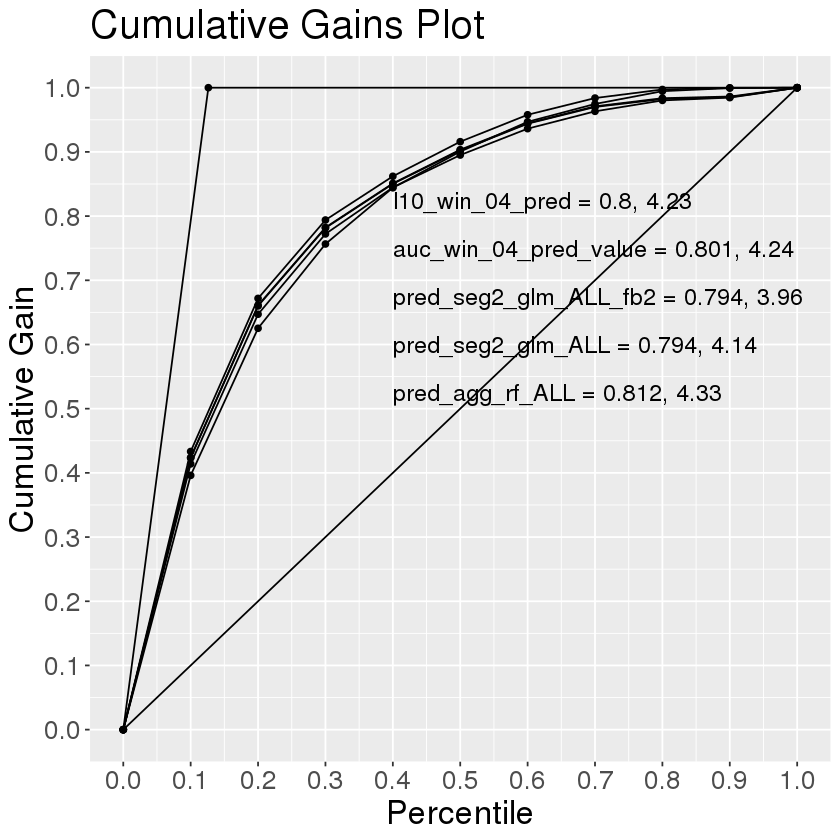

In [29]:
plot_multigains(            lift_df_list=lift_list,
                             auc_list = auc_list,
                             prop_positive = 0.1262565) 

# Compare Metrics

In [30]:
l10_df <- lapply(lift_list, function(x) x[x$P=='0.1','lift'])
l10_df
(l10_df$l10_win_04_pred-l10_df$pred_seg2_glm_ALL_fb2)/l10_df$pred_seg2_glm_ALL_fb2
(l10_df$auc_win_04_pred-l10_df$pred_seg2_glm_ALL_fb2)/l10_df$pred_seg2_glm_ALL_fb2

$l10_win_04_pred
[1] 4.23381

$auc_win_04_pred_value
[1] 4.237004

$pred_seg2_glm_ALL_fb2
[1] 3.960712

$pred_seg2_glm_ALL
[1] 4.139583

$pred_agg_rf_ALL
[1] 4.332828

[1] 0.06895161

[1] 0.06975806

In [31]:
data.frame(auc_list) 

(auc_list$l10_win_04_pred-auc_list$pred_seg2_glm_ALL_fb2)/auc_list$pred_seg2_glm_ALL_fb2
(auc_list$auc_win_04_pred-auc_list$pred_seg2_glm_ALL_fb2)/auc_list$pred_seg2_glm_ALL_fb2

l10_win_04_pred,auc_win_04_pred_value,pred_seg2_glm_ALL_fb2,pred_seg2_glm_ALL,pred_agg_rf_ALL
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.7999002,0.8006827,0.7938074,0.7937036,0.8115667


[1] 0.0076754

[1] 0.008661231

In [32]:
head(expiry_df_test_preds_assign)

,tld_registrar_index,reseller,reseller_country,domain_id,renewal_type,renewed_count,expiry_date,creation_date,status,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,⋯,pred_seg2_glm_ALL,pred_seg2_rf_ALL,reseller_geo,pred_agg_glm_ALL_fb,pred_agg_rf_ALL_fb,pred_agg_glm_fb,pred_agg_rf_fb,pred_seg_glm_ALL_fb,pred_seg_rf_ALL_fb,pred_seg2_glm_ALL_fb,pred_seg2_rf_ALL_fb,reg_arpt_org,reg_arpt_slab,pred_seg2_rf_ALL_fb2,pred_seg2_glm_ALL_fb2,pred_seg_rf_ALL_fb2,pred_seg_glm_ALL_fb2,pred_agg_rf_fb2,pred_agg_glm_fb2,pred_agg_rf_ALL_fb2,pred_agg_glm_ALL_fb2,l10_win_04_pred_model,auc_win_04_pred_model,l10_win_04_pred_value,auc_win_04_pred_value
,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,⋯,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
1,fun1api,1API,Germany,77112544,FirstTime,1,2019-09-21,2018-09-21,Active,alparty.fun,1API,NA,1,3,3,0,233136706,auto-renewal,unrealized,Not Renewd,2019-09-21,15,3.58,alparty,1,⋯,0.4780584,0.6233142,EU,NA,NA,NA,NA,NA,NA,NA,NA,3,"(1,3]",0.211,0.211,0.211,0.211,0.211,0.211,0.211,0.211,l10_seg2_glm,auc_seg2_glm,0.4780584,0.4780584
2,fun1api,1API,Germany,118771316,FirstTime,1,2020-08-20,2019-08-20,Active,echt-geil.fun,1API,NA,1,5,5,0,329057769,renewal,NA,Renewed,2020-07-13,15,2.00,echt-geil,1,⋯,NA,0.4911790,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm,NA,NA
3,fun1api,1API,Germany,101717674,FirstTime,1,2020-04-24,2019-04-24,Active,gotsome.fun,1API,NA,1,5,5,0,310645094,auto-renewal,unrealized,Not Renewd,2020-04-24,15,6.09,gotsome,1,⋯,0.6194136,0.6294112,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm,0.6194136,0.6194136
4,fun1api,1API,Germany,89153032,FirstTime,1,2019-12-29,2018-12-29,Active,noor.fun,1API,NA,1,3,3,0,263535836,renewal,NA,Renewed,2019-12-08,15,5.77,noor,1,⋯,0.4426250,0.3342575,EU,NA,NA,NA,NA,NA,NA,NA,NA,3,"(1,3]",0.211,0.211,0.211,0.211,0.211,0.211,0.211,0.211,l10_seg2_glm,auc_seg2_glm,0.4426250,0.4426250
5,fun1api,1API,Germany,118627451,FirstTime,1,2020-08-19,2019-08-19,Active,laurendoesstuff.fun,1API,NA,1,5,5,0,338522944,auto-renewal,unrealized,Not Renewd,2020-08-19,15,4.83,laurendoesstuff,1,⋯,0.7268515,0.6059519,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm,0.7268515,0.7268515
6,fun1api,1API,Germany,93057463,FirstTime,1,2020-02-07,2019-02-07,Active,bottegaveneta.fun,1API,NA,1,5,5,0,289674366,auto-renewal,realized,Renewed,2020-02-07,15,5.21,bottegaveneta,1,⋯,0.7021113,0.6055075,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm,0.7021113,0.7021113


In [33]:
# agg_rf vs. seg2_glm Sensitivity & Specificity at cutoff of .5 and =proppos

compare_function <- function(preds_df){
    compare_df = as.data.frame(list(
        'agg_rf_0.089'=confusionMatrix(as.factor(ifelse(preds_df$pred_agg_rf_ALL > 0.08937016, "Renewed", "Not Renewd")), 
                preds_df$renewal_status, positive="Renewed")$byClass,
        'seg2_glm_fb_0.089'=confusionMatrix(as.factor(ifelse(preds_df$pred_seg2_glm_ALL_fb2 > 0.08937016, "Renewed", "Not Renewd")), 
                preds_df$renewal_status, positive="Renewed")$byClass,
        'l10_win_04_0.089'=confusionMatrix(as.factor(ifelse(preds_df$l10_win_04_pred_value > 0.08937016, "Renewed", "Not Renewd")), 
                preds_df$renewal_status, positive="Renewed")$byClass,
        'auc_win_04_0.089'=confusionMatrix(as.factor(ifelse(preds_df$auc_win_04_pred_value > 0.08937016, "Renewed", "Not Renewd")), 
                preds_df$renewal_status, positive="Renewed")$byClass,
        'agg_rf_0.500'=confusionMatrix(as.factor(ifelse(preds_df$pred_agg_rf_ALL > 0.5, "Renewed", "Not Renewd")), 
                preds_df$renewal_status, positive="Renewed")$byClass,
        'seg2_glm_fb_0.500'=confusionMatrix(as.factor(ifelse(preds_df$pred_seg2_glm_ALL_fb2 > 0.5, "Renewed", "Not Renewd")), 
                preds_df$renewal_status, positive="Renewed")$byClass,
        'l10_win_04_0.500'=confusionMatrix(as.factor(ifelse(preds_df$l10_win_04_pred_value > 0.5, "Renewed", "Not Renewd")), 
                preds_df$renewal_status, positive="Renewed")$byClass,
        'auc_win_04_0.500'=confusionMatrix(as.factor(ifelse(preds_df$auc_win_04_pred_value > 0.5, "Renewed", "Not Renewd")), 
                preds_df$renewal_status, positive="Renewed")$byClass))
    return(compare_df)
}

# confres_list <- lapply(preds_prio_list,compare_function)
compare_function(expiry_df_test_preds_assign)

,agg_rf_0.089,seg2_glm_fb_0.089,l10_win_04_0.089,auc_win_04_0.089,agg_rf_0.500,seg2_glm_fb_0.500,l10_win_04_0.500,auc_win_04_0.500
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sensitivity,0.8354228,0.8099497,0.8288412,0.8303744,0.30032740,0.21448535,0.29260813,0.29067140
Specificity,0.7122796,0.7106180,0.7151761,0.7135079,0.97377227,0.97804163,0.97326228,0.97358665
Pos Pred Value,0.2955618,0.2879734,0.2946610,0.2938321,0.62330129,0.58531270,0.61105494,0.61237674
Neg Pred Value,0.9676909,0.9627922,0.9667841,0.9669974,0.90593969,0.89601260,0.90551639,0.90531078
Precision,0.2955618,0.2879734,0.2946610,0.2938321,0.62330129,0.58531270,0.61105494,0.61237674
Recall,0.8354228,0.8099497,0.8288412,0.8303744,0.30032740,0.21448535,0.29260813,0.29067140
F1,0.4366444,0.4248822,0.4347605,0.4340673,0.40534569,0.31393174,0.39572193,0.39422130
Prevalence,0.1262565,0.1262565,0.1255369,0.1255369,0.12625647,0.12625647,0.12553692,0.12553692
Detection Rate,0.1054775,0.1022614,0.1040502,0.1042426,0.03791828,0.02708016,0.03673312,0.03648999


In [34]:
x = compare_function(expiry_df_test_preds_assign)

cat("True Positive Improvement via L10 assignment  @ 0.089 cutoff")
(x['Sensitivity','l10_win_04_0.089']-
                                  x['Sensitivity','seg2_glm_fb_0.089'])/x['Sensitivity','seg2_glm_fb_0.089']

cat("\n\nTrue Positive Improvement via L10 assignment  @ 0.500 cutoff")
(x['Sensitivity','l10_win_04_0.500']-
                                  x['Sensitivity','seg2_glm_fb_0.500'])/x['Sensitivity','seg2_glm_fb_0.089']
       
cat("\n\nTrue Positive Improvement via AUC assignment  @ 0.089 cutoff")
(x['Sensitivity','auc_win_04_0.089']-
                                  x['Sensitivity','seg2_glm_fb_0.089'])/x['Sensitivity','seg2_glm_fb_0.089']

cat("\n\nTrue Positive Improvement via AUC assignment  @ 0.500 cutoff")
(x['Sensitivity','auc_win_04_0.500']-
                                  x['Sensitivity','seg2_glm_fb_0.500'])/x['Sensitivity','seg2_glm_fb_0.089']
  

True Positive Improvement via L10 assignment  @ 0.089 cutoff

[1] 0.02332428



True Positive Improvement via L10 assignment  @ 0.500 cutoff

[1] 0.09645388



True Positive Improvement via AUC assignment  @ 0.089 cutoff

[1] 0.0252173



True Positive Improvement via AUC assignment  @ 0.500 cutoff

[1] 0.0940627

# Examining how variables of high importance differ between classes in training & test data

In [35]:
var_imp <- as.data.frame(list(imp_l10=importance(model_l10), 
                              imp_auc=importance(model_auc)))  %>% arrange(desc(imp_l10))
# var_imp$var <- row.names(var_imp)
# row.names(var_imp) <- NULL
# var_imp <- var_imp %>% arrange(desc(imp))
head(var_imp,10)

,imp_l10,imp_auc
,<dbl>,<dbl>
n,29.79090,30.445214
gibbs_rng,24.18371,23.114864
sldlen_kurt,21.77440,24.281857
daydom_rng,18.29000,21.056911
gibbs_max,17.13786,13.123573
ren_prp,16.02285,22.351058
daydom_max,14.78862,15.964549
sldlen_rng,14.62357,20.991639
pdcnt_max,12.94187,6.497822


In [36]:
train %>% 
  group_by(auc_win_04) %>%
  summarize(mean_n = mean(n), 
           mean_gibbs_rng = mean(gibbs_rng),
           mean_sldlen_kurt = mean(sldlen_kurt),
           mean_daydom_rng = mean(daydom_rng),
           mean_daydom_max = mean(daydom_max),
           mean_gibbs_max = mean(gibbs_max),
           mean_ren_prp = mean(ren_prp),
           mean_daydom_kurt = mean(daydom_kurt),
           mean_gibbs_kurt = mean(gibbs_kurt),
           mean_daydom_mean = mean(daydom_mean)
           ) %>% t()

`summarise()` ungrouping output (override with `.groups` argument)



auc_win_04,auc_agg_rf_ALL,auc_seg2_glm,auc_seg2_glm_fb
mean_n,1479.9168,105.7423,29.9680
mean_gibbs_rng,42.98483,15.44032,21.77784
mean_sldlen_kurt,2.6320948,-0.5861724,0.1395763
mean_daydom_rng,524.86931,46.60309,8.63200
mean_daydom_max,526.8693,48.0799,9.6400
mean_gibbs_max,43.56354,17.79714,22.93048
mean_ren_prp,0.2823108,0.3930800,0.3890438
mean_daydom_kurt,2.0498641,-0.3566503,0.2587341
mean_gibbs_kurt,56.653847,11.659877,2.979369
mean_daydom_mean,191.213125,21.051315,3.707608


In [37]:
train %>% 
  group_by(l10_win_04) %>%
  summarize(mean_n = mean(n), 
           mean_gibbs_rng = mean(gibbs_rng),
           mean_sldlen_kurt = mean(sldlen_kurt),
           mean_daydom_rng = mean(daydom_rng),
           mean_daydom_max = mean(daydom_max),
           mean_gibbs_max = mean(gibbs_max),
           mean_ren_prp = mean(ren_prp),
           mean_daydom_kurt = mean(daydom_kurt),
           mean_gibbs_kurt = mean(gibbs_kurt),
           mean_daydom_mean = mean(daydom_mean)
           ) %>% t()

`summarise()` ungrouping output (override with `.groups` argument)



l10_win_04,l10_agg_rf_ALL,l10_seg2_glm,l10_seg2_glm_fb
mean_n,1885.88451,116.89677,38.39394
mean_gibbs_rng,49.84307,16.68422,21.52848
mean_sldlen_kurt,3.5383846,-0.5261159,0.7303890
mean_daydom_rng,661.71129,51.69552,9.30303
mean_daydom_max,663.96850,53.10949,10.30303
mean_gibbs_max,50.31304,18.79761,22.42879
mean_ren_prp,0.2608439,0.3885171,0.3675474
mean_daydom_kurt,2.4259604,-0.1601276,0.3035447
mean_gibbs_kurt,71.70236,10.84540,4.71722
mean_daydom_mean,242.981941,21.389805,4.135719


# FUP for Parag: 
## tabular (& visual) representation -- which registrars, which model (reseller priority level) 
## also performance metrics, see below (but that may be for the following Th)

### 1. Tabular

In [71]:
# add resellerand tld columns to metalearning predictions
expiry_test_lookup <- expiry_df_test_preds %>% select(tld_registrar_index,reseller, tld) %>% distinct()
vis_df <- merge(expiry_test_lookup,
                test_pred, by="tld_registrar_index", all.y=TRUE) 
vis_df <- vis_df%>% rename_at(ncol(.), ~"l10_win_04_pred_model")
vis_df <- vis_df%>% rename_at(ncol(.)-1, ~"auc_win_04_pred_model")
# add reseller priority columns to metalearning predictions
priorityLookup_df <- read.csv("/home/jupyter/Domains_202003/data/data_input/PredictiveModelAnalysis_ResellerPriorityList.csv")
names(priorityLookup_df) <- c("market","reseller","npv2020","priority")
priorityLookup_df$reseller <- tolower(priorityLookup_df$reseller)
vis_df$reseller <- tolower(vis_df$reseller)
vis_df <- merge(vis_df, priorityLookup_df, by="reseller", all.x=TRUE)



dim(vis_df)
head(vis_df)

[1] 360  87

,reseller,tld_registrar_index,tld,geo_maj,geo_cnt,n,ren_prp,tld_cnt,tld_rat,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,⋯,auc_agg_rf_ALL,auc_agg_rf,l10_seg2_glm_fb,l10_seg_glm_fb,l10_agg_glm_fb,l10_agg_glm_ALL_fb,l10_seg2_rf_fb,l10_seg_rf_fb,l10_agg_rf_fb,l10_agg_rf_ALL_fb,auc_seg2_glm_fb,auc_seg_glm_fb,auc_agg_glm_fb,auc_agg_glm_ALL_fb,auc_seg2_rf_fb,auc_seg_rf_fb,auc_agg_rf_fb,auc_agg_rf_ALL_fb,auc_win_04,l10_win_04,auc_win_04_pred_model,l10_win_04_pred_model,market,npv2020,priority
,<chr>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>,<fct>,<int>,<int>
1,1&1 internet,website1&1 internet,website,EU,1,79,0.5443038,1,0.012658228,1,39,5.670886,38,9.0903182,3.0802426,8.470809,3,24,10.455696,21,3.983290,0.6198044,0.5446076,0.30,10.04,⋯,0.5872093,0.4709302,1.162791,1.162791,1.162791,1.162791,1.162791,1.162791,1.162791,1.162791,0.5430233,0.5430233,0.5430233,0.5430233,0.5430233,0.5430233,0.5430233,0.5430233,auc_agg_rf_ALL,l10_seg2_glm,l10_agg_rf_ALL,auc_agg_rf_ALL,Europe,770943,1
2,1&1 internet,space1&1 internet,space,EU,1,136,0.4264706,1,0.007352941,1,40,6.625000,39,8.3470443,2.8362850,8.463461,4,46,9.345588,42,4.551562,4.0689470,29.0915153,0.05,100.00,⋯,0.5879310,0.5413793,1.551724,1.551724,1.551724,1.551724,1.551724,1.551724,1.551724,1.551724,0.6034483,0.6034483,0.6034483,0.6034483,0.6034483,0.6034483,0.6034483,0.6034483,auc_seg2_glm_fb,l10_agg_rf_ALL,l10_agg_rf_ALL,auc_agg_rf_ALL,Europe,770943,1
3,1api,website1api,website,EU,1,8,0.6250000,1,0.125000000,1,3,1.625000,2,0.7440238,0.5405979,-1.268779,8,13,10.125000,5,1.726888,0.4164278,-1.5035873,2.25,7.84,⋯,0.6100000,0.5500000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.5900000,0.5900000,0.5900000,0.5900000,0.5900000,0.5900000,0.5900000,0.5900000,auc_agg_rf_ALL,l10_seg2_glm,l10_seg2_glm,auc_agg_rf_ALL,Europe,61549,3
4,1api,fun1api,fun,EU,1,8,0.5000000,1,0.125000000,1,1,1.000000,0,0.0000000,1.5658080,1.156440,4,15,8.875000,11,3.522884,0.4848693,-1.1434523,2.00,6.09,⋯,0.3500000,0.5500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,auc_seg2_glm_fb,l10_seg2_glm_fb,l10_seg2_glm,auc_seg2_glm,Europe,61549,3
5,1api,tech1api,tech,EU,1,55,0.6545455,1,0.018181818,1,77,23.472727,76,34.6045675,0.8950600,-1.219083,4,29,8.509091,25,3.775519,2.8024027,13.3155453,0.20,9.65,⋯,0.5666667,0.5722222,1.388889,1.388889,1.388889,1.388889,1.388889,1.388889,1.388889,1.388889,0.5583333,0.5583333,0.5583333,0.5583333,0.5583333,0.5583333,0.5583333,0.5583333,auc_seg2_glm,l10_seg2_glm,l10_agg_rf_ALL,auc_agg_rf_ALL,Europe,61549,3
6,1blu,online1blu,online,EU,1,22,0.5909091,1,0.045454545,1,7,3.227273,6,2.4675382,0.4403861,-1.669712,4,25,9.727273,21,4.900746,1.1628317,1.7253155,0.52,12.00,⋯,0.6423077,0.4423077,1.538462,1.538462,1.538462,1.538462,1.538462,1.538462,1.538462,1.538462,0.6500000,0.6500000,0.6500000,0.6500000,0.6500000,0.6500000,0.6500000,0.6500000,auc_seg2_glm_fb,l10_agg_rf_ALL,l10_seg2_glm,auc_agg_rf_ALL,Europe,2578,4


In [87]:
# by tld-reseller
vis_df_01 <- vis_df %>% select(tld_registrar_index, auc_win_04_pred_model,l10_win_04_pred_model)
dim(vis_df_01)
head(vis_df_01)
# by reseller
vis_df_02 <- vis_df %>% select(reseller, auc_win_04_pred_model,l10_win_04_pred_model)
vis_df_02_01 <- vis_df_02 %>%
  group_by(reseller, auc_win_04_pred_model) %>%
  summarise(n = n()) %>%
  mutate(freq = round(n / sum(n),2))
vis_df_02_02 <- vis_df_02 %>%
  group_by(reseller, l10_win_04_pred_model) %>%
  summarise(n = n()) %>%
  mutate(freq = round(n / sum(n),2))
# by tld
vis_df_03 <- vis_df %>% select(tld, auc_win_04_pred_model,l10_win_04_pred_model) 
vis_df_03_01 <- vis_df_03 %>%
  group_by(tld, auc_win_04_pred_model) %>%
  summarise(n = n()) %>%
  mutate(freq = round(n / sum(n),2))
vis_df_03_02 <- vis_df_03 %>%
  group_by(tld, l10_win_04_pred_model) %>%
  summarise(n = n()) %>%
  mutate(freq = round(n / sum(n),2))
head(vis_df_03_01)
head(vis_df_03_02)
# by priority
vis_df_04 <- vis_df %>% select(priority, auc_win_04_pred_model,l10_win_04_pred_model)
vis_df_04_01 <- vis_df_04 %>%
  group_by(priority, auc_win_04_pred_model) %>%
  summarise(n = n()) %>%
  mutate(freq = round(n / sum(n),2))
vis_df_04_02 <- vis_df_04 %>%
  group_by(priority, l10_win_04_pred_model) %>%
  summarise(n = n()) %>%
  mutate(freq = round(n / sum(n),2))
head(vis_df_04_01)
vis_df_04_02



[1] 360   3

,tld_registrar_index,auc_win_04_pred_model,l10_win_04_pred_model
,<fct>,<fct>,<fct>
1,website1&1 internet,l10_agg_rf_ALL,auc_agg_rf_ALL
2,space1&1 internet,l10_agg_rf_ALL,auc_agg_rf_ALL
3,website1api,l10_seg2_glm,auc_agg_rf_ALL
4,fun1api,l10_seg2_glm,auc_seg2_glm
5,tech1api,l10_agg_rf_ALL,auc_agg_rf_ALL
6,online1blu,l10_seg2_glm,auc_agg_rf_ALL


`summarise()` regrouping output by 'reseller' (override with `.groups` argument)

`summarise()` regrouping output by 'reseller' (override with `.groups` argument)

`summarise()` regrouping output by 'tld' (override with `.groups` argument)

`summarise()` regrouping output by 'tld' (override with `.groups` argument)



tld,auc_win_04_pred_model,n,freq
<fct>,<fct>,<int>,<dbl>
fun,l10_agg_rf_ALL,6,0.26
fun,l10_seg2_glm,17,0.74
host,l10_agg_rf_ALL,2,0.13
host,l10_seg2_glm,13,0.87
in.net,l10_seg2_glm,5,1.00
online,l10_agg_rf_ALL,27,0.44


tld,l10_win_04_pred_model,n,freq
<fct>,<fct>,<int>,<dbl>
fun,auc_agg_rf_ALL,12,0.52
fun,auc_seg2_glm,11,0.48
host,auc_agg_rf_ALL,1,0.07
host,auc_seg2_glm,14,0.93
in.net,auc_seg2_glm,5,1.00
online,auc_agg_rf_ALL,39,0.64


`summarise()` regrouping output by 'priority' (override with `.groups` argument)

`summarise()` regrouping output by 'priority' (override with `.groups` argument)



priority,auc_win_04_pred_model,n,freq
<int>,<fct>,<int>,<dbl>
1,l10_agg_rf_ALL,34,0.65
1,l10_seg2_glm,18,0.35
2,l10_agg_rf_ALL,16,0.44
2,l10_seg2_glm,20,0.56
3,l10_agg_rf_ALL,18,0.24
3,l10_seg2_glm,58,0.76


priority,l10_win_04_pred_model,n,freq
<int>,<fct>,<int>,<dbl>
1,auc_agg_rf_ALL,38,0.73
1,auc_seg2_glm,13,0.25
1,auc_seg2_glm_fb,1,0.02
2,auc_agg_rf_ALL,26,0.72
2,auc_seg2_glm,10,0.28
3,auc_agg_rf_ALL,32,0.42
3,auc_seg2_glm,42,0.55
3,auc_seg2_glm_fb,2,0.03
4,auc_agg_rf_ALL,58,0.33


In [86]:
vis_df %>% filter((priority==1) & (l10_win_04_pred_model=='auc_seg2_glm'))

reseller,tld_registrar_index,tld,geo_maj,geo_cnt,n,ren_prp,tld_cnt,tld_rat,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,⋯,auc_agg_rf_ALL,auc_agg_rf,l10_seg2_glm_fb,l10_seg_glm_fb,l10_agg_glm_fb,l10_agg_glm_ALL_fb,l10_seg2_rf_fb,l10_seg_rf_fb,l10_agg_rf_fb,l10_agg_rf_ALL_fb,auc_seg2_glm_fb,auc_seg_glm_fb,auc_agg_glm_fb,auc_agg_glm_ALL_fb,auc_seg2_rf_fb,auc_seg_rf_fb,auc_agg_rf_fb,auc_agg_rf_ALL_fb,auc_win_04,l10_win_04,auc_win_04_pred_model,l10_win_04_pred_model,market,npv2020,priority
<chr>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>,<fct>,<int>,<int>
crazy domains,hostcrazy domains,host,Australia & New Zealand,1,1,0.0000000,1,1.000000000,1,1,1.000000,0,61.4424318,-0.03554604,-1.2509211,10,10,10.000000,0,1.705473,0.074442081,-1.6861611,5.19,5.19,⋯,0.9456847,0.9438163,9.510915,9.621184,9.492300,9.052705,9.972577,9.993181,9.982575,9.995849,0.9451823,0.9445205,0.9452628,0.9451901,0.9483675,0.9499430,0.9500000,0.9494340,auc_seg2_glm,l10_seg2_glm,l10_seg2_glm,auc_seg2_glm,Australia,421032,1
cronon ag,presscronon ag,press,EU,1,2,0.5000000,1,0.500000000,1,1,1.000000,0,0.0000000,0.13481990,-2.2009734,6,6,6.000000,0,0.000000,0.006091721,-2.7225298,2.38,2.85,⋯,0.2500000,0.2500000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.9500000,0.9500000,0.9500000,0.9500000,0.9500000,0.9500000,0.9500000,0.9500000,auc_seg2_glm,l10_seg2_glm,l10_seg2_glm,auc_seg2_glm,Europe,638071,1
fbs,pwfbs,pw,Turkey,1,1,1.0000000,1,1.000000000,4,4,4.000000,0,4.9487764,-0.03981704,-2.4833557,15,15,15.000000,0,2.462805,-0.016458580,-2.3683921,1.49,1.49,⋯,0.9500000,0.9500000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.9500000,0.9500000,0.9500000,0.9500000,0.9500000,0.9500000,0.9500000,0.9500000,auc_seg2_glm,l10_seg2_glm,l10_seg2_glm,auc_seg2_glm,Turkey,21131,1
gandi sas,pressgandi sas,press,EU,1,26,0.2692308,1,0.038461538,1,5,1.461538,4,0.9891721,2.12894675,4.0162922,3,21,8.653846,18,4.107966,1.240665503,1.5689448,0.51,9.95,⋯,0.5928571,0.5357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.4928571,0.4928571,0.4928571,0.4928571,0.4928571,0.4928571,0.4928571,0.4928571,auc_agg_rf_ALL,l10_seg2_glm,l10_seg2_glm,auc_seg2_glm,Europe,363233,1
gmo,in.netgmo,in.net,Japan,1,13,0.2307692,1,0.076923077,1,6,2.846154,5,2.0349510,0.57492730,-1.3954523,4,16,9.461538,12,3.550009,-0.001159809,-1.2518858,0.04,8.07,⋯,0.7833333,0.7500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.3833333,0.3833333,0.3833333,0.3833333,0.3833333,0.3833333,0.3833333,0.3833333,auc_agg_rf_ALL,l10_seg2_glm,l10_seg2_glm,auc_seg2_glm,Asia,373844,1
gmo,storegmo,store,Japan,1,3,1.0000000,1,0.333333333,1,2,1.333333,1,0.5773503,0.38490018,-2.3333333,4,10,7.666667,6,3.214550,-0.343420561,-2.3333333,3.93,7.91,⋯,0.5500000,0.5500000,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,auc_seg2_glm,l10_seg2_glm,l10_seg2_glm,auc_seg2_glm,Asia,373844,1
muumuu,websitemuumuu,website,Japan,1,67,0.5671642,1,0.014925373,1,5,2.089552,4,1.0692867,0.99712482,0.5062093,3,19,8.477612,16,3.718741,0.858759680,0.4603623,0.10,100.00,⋯,0.5552632,0.5157895,1.052632,1.052632,1.052632,1.052632,1.052632,1.052632,1.052632,1.052632,0.4947368,0.4947368,0.4947368,0.4947368,0.4947368,0.4947368,0.4947368,0.4947368,auc_agg_rf_ALL,l10_agg_rf_ALL,l10_seg2_glm,auc_seg2_glm,Asia,219634,1
muumuu,spacemuumuu,space,Japan,1,104,0.5192308,1,0.009615385,1,8,2.538462,7,1.4273547,1.39132044,2.6521205,3,22,8.817308,19,3.646422,1.020997354,1.0471229,0.17,12.70,⋯,0.5370370,0

In [76]:
# cross section graph of tld vs reseller and model (w/ shading) in the intersection: 
#    https://www.r-graph-gallery.com/79-levelplot-with-ggplot2.html
# by reseller:  percentage of each model assigned
# by tld:  percentage of each model assigned
# by priority: percentage of each model assigned

In [64]:
head(test_pred)

,tld_registrar_index,geo_maj,geo_cnt,n,ren_prp,tld_cnt,tld_rat,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,⋯,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf_ALL,auc_agg_rf,l10_seg2_glm_fb,l10_seg_glm_fb,l10_agg_glm_fb,l10_agg_glm_ALL_fb,l10_seg2_rf_fb,l10_seg_rf_fb,l10_agg_rf_fb,l10_agg_rf_ALL_fb,auc_seg2_glm_fb,auc_seg_glm_fb,auc_agg_glm_fb,auc_agg_glm_ALL_fb,auc_seg2_rf_fb,auc_seg_rf_fb,auc_agg_rf_fb,auc_agg_rf_ALL_fb,auc_win_04,l10_win_04,pred_l10$l10_win_04_pred_model,pred_auc$auc_win_04_pred_model
,<fct>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
3,fun1api,EU,1,8,0.50000000,1,0.125000000,1,1,1.000000,0,0.0000000,1.5658080,1.1564401,4,15,8.875000,11,3.5228844,0.4848693,-1.143452,2.00,6.09,4.396250,4.09,⋯,0.4250000,0.3500000,0.4750000,0.3500000,0.5500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,auc_seg2_glm_fb,l10_seg2_glm_fb,l10_seg2_glm,auc_seg2_glm
7,funalibaba sg,China,1,195,0.04102564,1,0.005128205,1,490,296.728205,489,228.3117623,-0.3415584,-1.8644672,4,15,6.794872,11,2.3106598,1.4636429,1.315210,0.12,16.72,4.425128,16.60,⋯,0.8625000,0.8875000,0.8750000,0.8750000,0.8750000,7.500000,5.000000,6.250000,6.250000,3.750000,2.500000,3.750000,3.750000,0.9250000,0.9000000,0.8625000,0.8500000,0.8875000,0.8750000,0.8750000,0.8750000,auc_seg2_glm,l10_seg2_glm,l10_agg_rf_ALL,auc_agg_rf_ALL
15,funcafe24,"Vietnam, Korea & Indonesia",1,3,0.00000000,1,0.333333333,1,2,1.333333,1,0.5773503,0.3849002,-2.3333333,5,6,5.666667,1,0.5773503,-0.3849002,-2.333333,0.48,5.80,2.926667,5.32,⋯,0.6000376,0.6546695,0.6871427,0.6360214,0.5983887,4.269437,4.363352,4.031874,4.008743,4.829749,4.852859,4.669066,4.758851,0.6076759,0.6139171,0.6158047,0.5954856,0.6227286,0.6291192,0.6194290,0.6157651,auc_seg2_glm,l10_seg2_glm,l10_seg2_glm,auc_seg2_glm
21,funcronon ag,EU,1,10,0.70000000,1,0.100000000,1,3,1.400000,2,0.6992059,1.1935618,-0.0746281,3,24,11.400000,21,7.3966960,0.7355118,-1.053701,1.05,100.00,13.731000,98.95,⋯,0.6500000,0.6500000,0.6500000,0.6500000,0.5785714,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,0.5071429,0.5071429,0.5071429,0.5071429,0.5071429,0.5071429,0.5071429,0.5071429,auc_seg2_glm,l10_seg2_glm,l10_seg2_glm,auc_agg_rf_ALL
22,funcsc corporate,United States,1,3,1.00000000,1,0.333333333,1,4,3.000000,3,1.7320508,-0.3849002,-2.3333333,11,16,14.000000,5,2.6457513,-0.3239695,-2.333333,4.71,6.28,5.233333,1.57,⋯,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,auc_seg2_glm,l10_seg2_glm,l10_seg2_glm,auc_seg2_glm
43,funglobal domains,United States,1,271,0.00000000,1,0.003690037,1,71,32.129151,70,20.7593334,0.4921998,-0.8367946,4,23,11.025830,19,3.6223684,1.0939010,1.296427,0.52,12.22,5.511661,11.70,⋯,0.6808176,0.8503536,0.8506547,0.8514446,0.8429044,4.789892,4.669712,3.382280,3.507468,5.424845,5.820438,5.325877,5.228621,0.7781662,0.7643041,0.6961987,0.7015210,0.8323627,0.8491662,0.8370442,0.8319197,auc_agg_rf_ALL,l10_agg_rf_ALL,l10_agg_rf_ALL,auc_agg_rf_ALL


In [65]:
vis_df <- merge(expiry_df_test_preds %>% select(tld_registrar_index,reseller, tld) %>% distinct(),
                test_pred, by="tld_registrar_index", all.y=TRUE) 
dim(vis_df)
names(vis_df)
head(vis_df)

[1] 360  84

[1] "tld_registrar_index"   "reseller"              "tld"                  
 [4] "geo_maj"               "geo_cnt"               "n"                    
 [7] "ren_prp"               "tld_cnt"               "tld_rat"              
[10] "daydom_min"            "daydom_max"            "daydom_mean"          
[13] "daydom_rng"            "daydom_std"            "daydom_skew"          
[16] "daydom_kurt"           "sldlen_min"            "sldlen_max"           
[19] "sldlen_mean"           "sldlen_rng"            "sldlen_std"           
[22] "sldlen_skew"           "sldlen_kurt"           "gibbs_min"            
[25] "gibbs_max"             "gibbs_mean"            "gibbs_rng"            
[28] "gibbs_std"             "gibbs_skew"            "gibbs_kurt"           
[31] "pdcnt_min"             "pdcnt_max"             "pdcnt_mean"           
[34] "pdcnt_rng"             "pdcnt_std"             "pdcnt_skew"           
[37] "pdcnt_kurt"            "regarpt_min"           "regarpt_max"          
[40] "regarpt_mean"          "regarpt_rng"           "regarpt_std"          
[43] "regarpt_skew"          "regarpt_kurt"          "country_maj"          
[46] "region_maj"            "country_cnt"           "region_cnt"           
[49] "l10_seg2_glm"          "l10_seg_glm"           "l10_agg_glm_ALL"      
[52] "l10_agg_glm"           "l10_seg2_rf"           "l10_seg_rf"           
[55] "l10_agg_rf"            "l10_agg_rf_ALL"        "auc_seg2_glm"         
[58] "auc_seg_glm"           "auc_agg_glm_ALL"       "auc_agg_glm"          
[61] "auc_seg2_rf"           "auc_seg_rf"            "auc_agg_rf_ALL"       
[64] "auc_agg_rf"            "l10_seg2_glm_fb"       "l10_seg_glm_fb"       
[67] "l10_agg_glm_fb"        "l10_agg_glm_ALL_fb"    "l10_seg2_rf_fb"       
[70] "l10_seg_rf_fb"         "l10_agg_rf_fb"         "l10_agg_rf_ALL_fb"    
[73] "auc_seg2_glm_fb"       "auc_seg_glm_fb"        "auc_agg_glm_fb"       
[76] "auc_agg_glm_ALL_fb"    "auc_seg2_rf_fb"        "auc_seg_rf_fb"        
[79] "auc_agg_rf_fb"         "auc_agg_rf_ALL_fb"     "auc_win_04"           
[82] "l10_win_04"            "auc_win_04_pred_model" "l10_win_04_pred_model"

,tld_registrar_index,reseller,tld,geo_maj,geo_cnt,n,ren_prp,tld_cnt,tld_rat,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,⋯,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf_ALL,auc_agg_rf,l10_seg2_glm_fb,l10_seg_glm_fb,l10_agg_glm_fb,l10_agg_glm_ALL_fb,l10_seg2_rf_fb,l10_seg_rf_fb,l10_agg_rf_fb,l10_agg_rf_ALL_fb,auc_seg2_glm_fb,auc_seg_glm_fb,auc_agg_glm_fb,auc_agg_glm_ALL_fb,auc_seg2_rf_fb,auc_seg_rf_fb,auc_agg_rf_fb,auc_agg_rf_ALL_fb,auc_win_04,l10_win_04,auc_win_04_pred_model,l10_win_04_pred_model
,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
1,fun1api,1API,fun,EU,1,8,0.50000000,1,0.125000000,1,1,1.000000,0,0.0000000,1.5658080,1.1564401,4,15,8.875000,11,3.5228844,0.4848693,-1.143452,2.00,6.09,⋯,0.4250000,0.3500000,0.4750000,0.3500000,0.5500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,auc_seg2_glm_fb,l10_seg2_glm_fb,l10_seg2_glm,auc_seg2_glm
2,funalibaba sg,Alibaba SG,fun,China,1,195,0.04102564,1,0.005128205,1,490,296.728205,489,228.3117623,-0.3415584,-1.8644672,4,15,6.794872,11,2.3106598,1.4636429,1.315210,0.12,16.72,⋯,0.8625000,0.8875000,0.8750000,0.8750000,0.8750000,7.500000,5.000000,6.250000,6.250000,3.750000,2.500000,3.750000,3.750000,0.9250000,0.9000000,0.8625000,0.8500000,0.8875000,0.8750000,0.8750000,0.8750000,auc_seg2_glm,l10_seg2_glm,l10_agg_rf_ALL,auc_agg_rf_ALL
3,funcafe24,Cafe24,fun,"Vietnam, Korea & Indonesia",1,3,0.00000000,1,0.333333333,1,2,1.333333,1,0.5773503,0.3849002,-2.3333333,5,6,5.666667,1,0.5773503,-0.3849002,-2.333333,0.48,5.80,⋯,0.6000376,0.6546695,0.6871427,0.6360214,0.5983887,4.269437,4.363352,4.031874,4.008743,4.829749,4.852859,4.669066,4.758851,0.6076759,0.6139171,0.6158047,0.5954856,0.6227286,0.6291192,0.6194290,0.6157651,auc_seg2_glm,l10_seg2_glm,l10_seg2_glm,auc_seg2_glm
4,funcronon ag,Cronon AG,fun,EU,1,10,0.70000000,1,0.100000000,1,3,1.400000,2,0.6992059,1.1935618,-0.0746281,3,24,11.400000,21,7.3966960,0.7355118,-1.053701,1.05,100.00,⋯,0.6500000,0.6500000,0.6500000,0.6500000,0.5785714,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,0.5071429,0.5071429,0.5071429,0.5071429,0.5071429,0.5071429,0.5071429,0.5071429,auc_seg2_glm,l10_seg2_glm,l10_seg2_glm,auc_agg_rf_ALL
5,funcsc corporate,CSC Corporate,fun,United States,1,3,1.00000000,1,0.333333333,1,4,3.000000,3,1.7320508,-0.3849002,-2.3333333,11,16,14.000000,5,2.6457513,-0.3239695,-2.333333,4.71,6.28,⋯,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,auc_seg2_glm,l10_seg2_glm,l10_seg2_glm,auc_seg2_glm
6,funglobal domains,Global Domains,fun,United States,1,271,0.00000000,1,0.003690037,1,71,32.129151,70,20.7593334,0.4921998,-0.8367946,4,23,11.025830,19,3.6223684,1.0939010,1.296427,0.52,12.22,⋯,0.6808176,0.8503536,0.8506547,0.8514446,0.8429044,4.789892,4.669712,3.382280,3.507468,5.424845,5.820438,5.325877,5.228621,0.7781662,0.7643041,0.6961987,0.7015210,0.8323627,0.8491662,0.8370442,0.8319197,auc_agg_rf_ALL,l10_agg_rf_ALL,l10_agg_rf_ALL,auc_agg_rf_ALL


In [66]:
(vis_df$reseller)[order(vis_df$n)][c(23,24,25)]

[1] HostEurope Online Sas Rumahweb  
323 Levels:  1&1 Internet 101 Domain 10dencehispahard 123-reg ... ZhuHai NaiSiNiKe

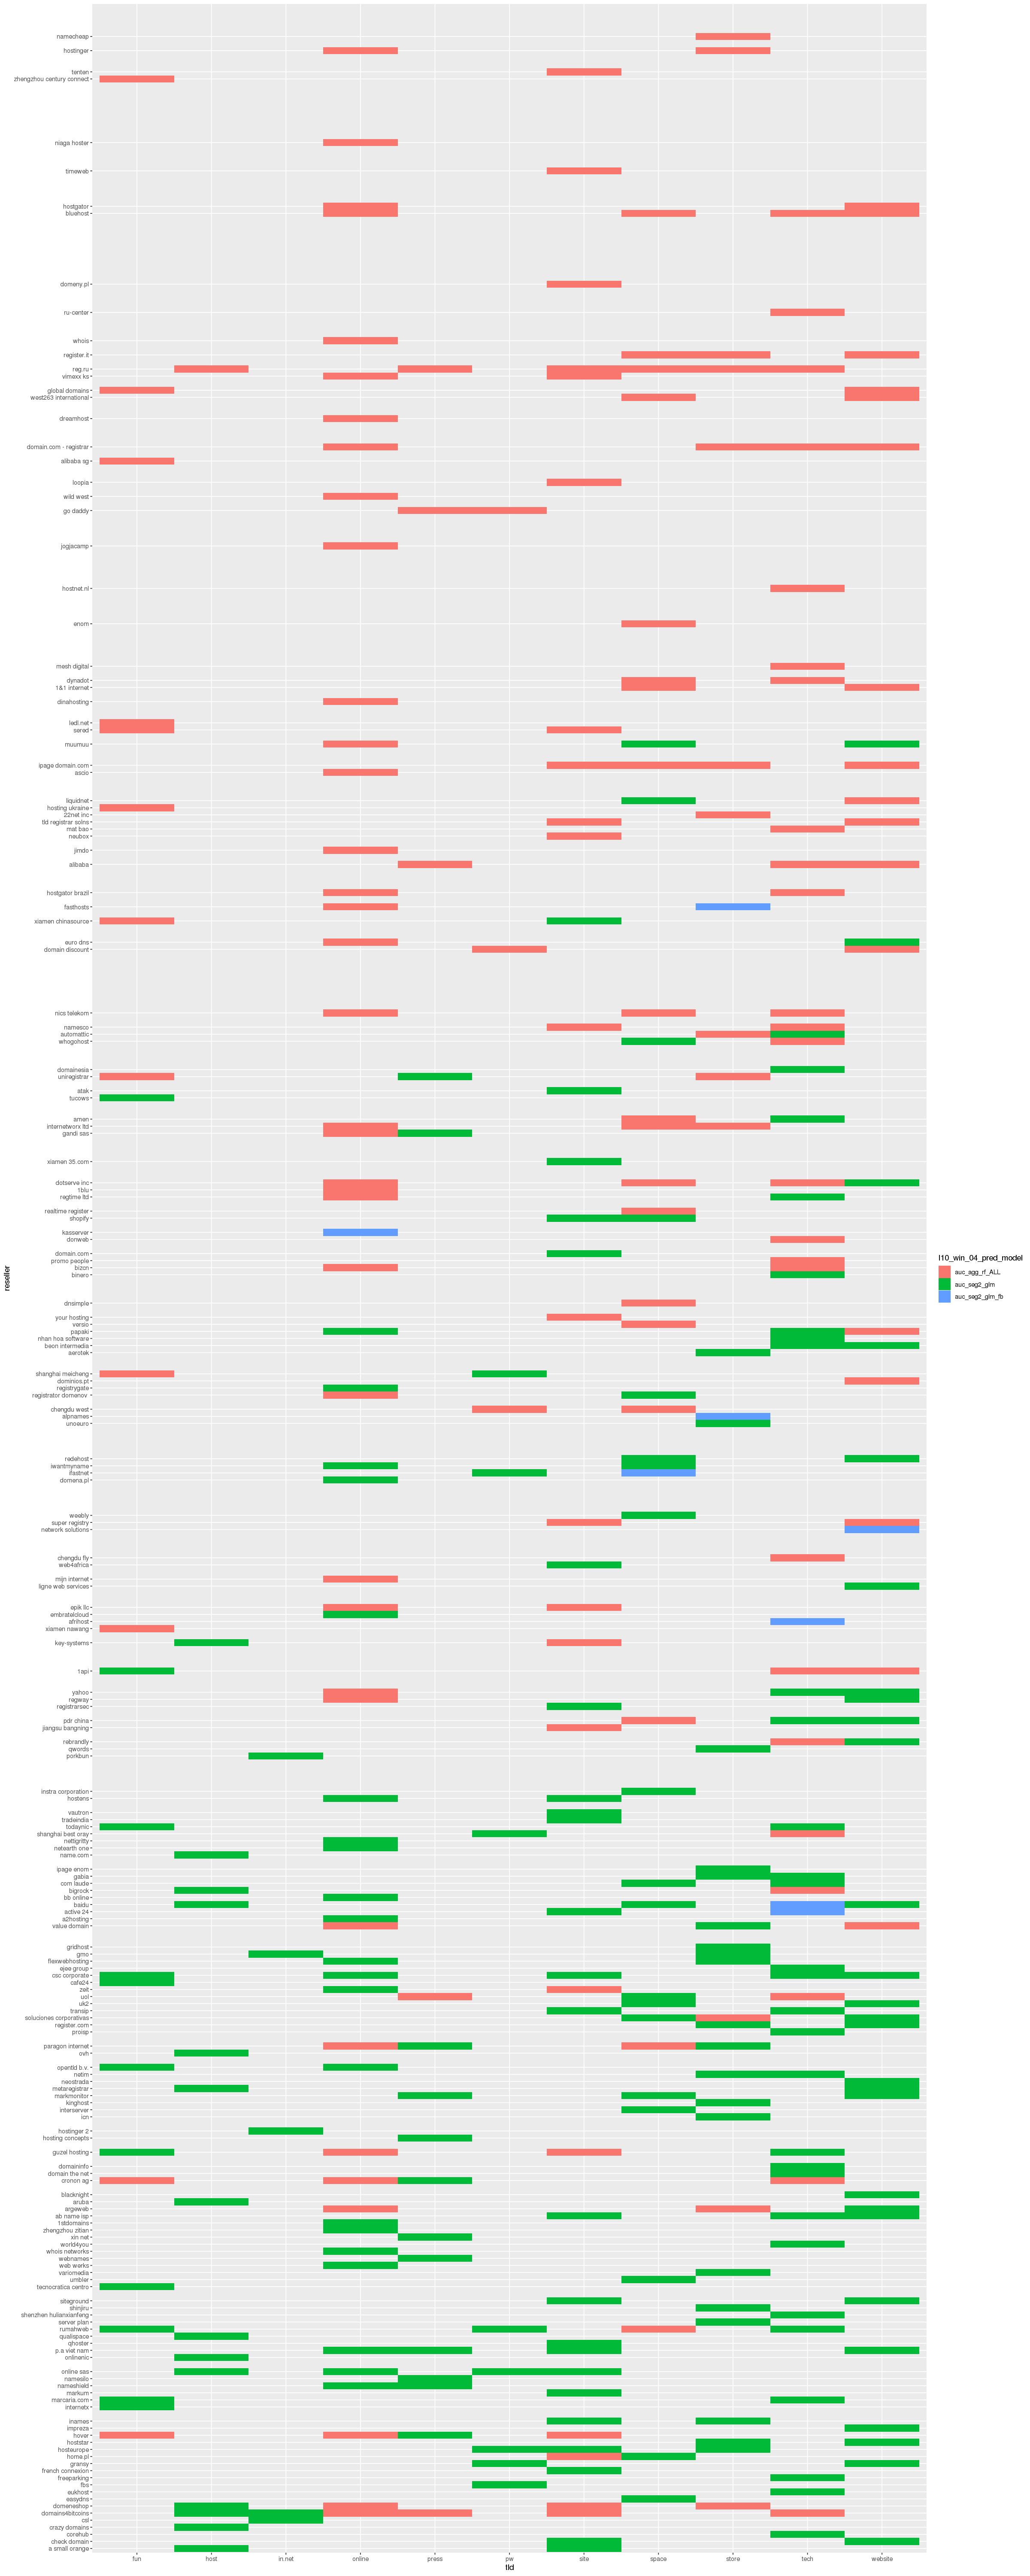

In [92]:
library(repr)
options(repr.plot.width=20, repr.plot.height=50)
ggplot(vis_df, 
       aes(tld, reseller, fill=l10_win_04_pred_model)) + 
  geom_tile() + 
  scale_y_discrete(limits=(vis_df$reseller)[order(vis_df$n)])


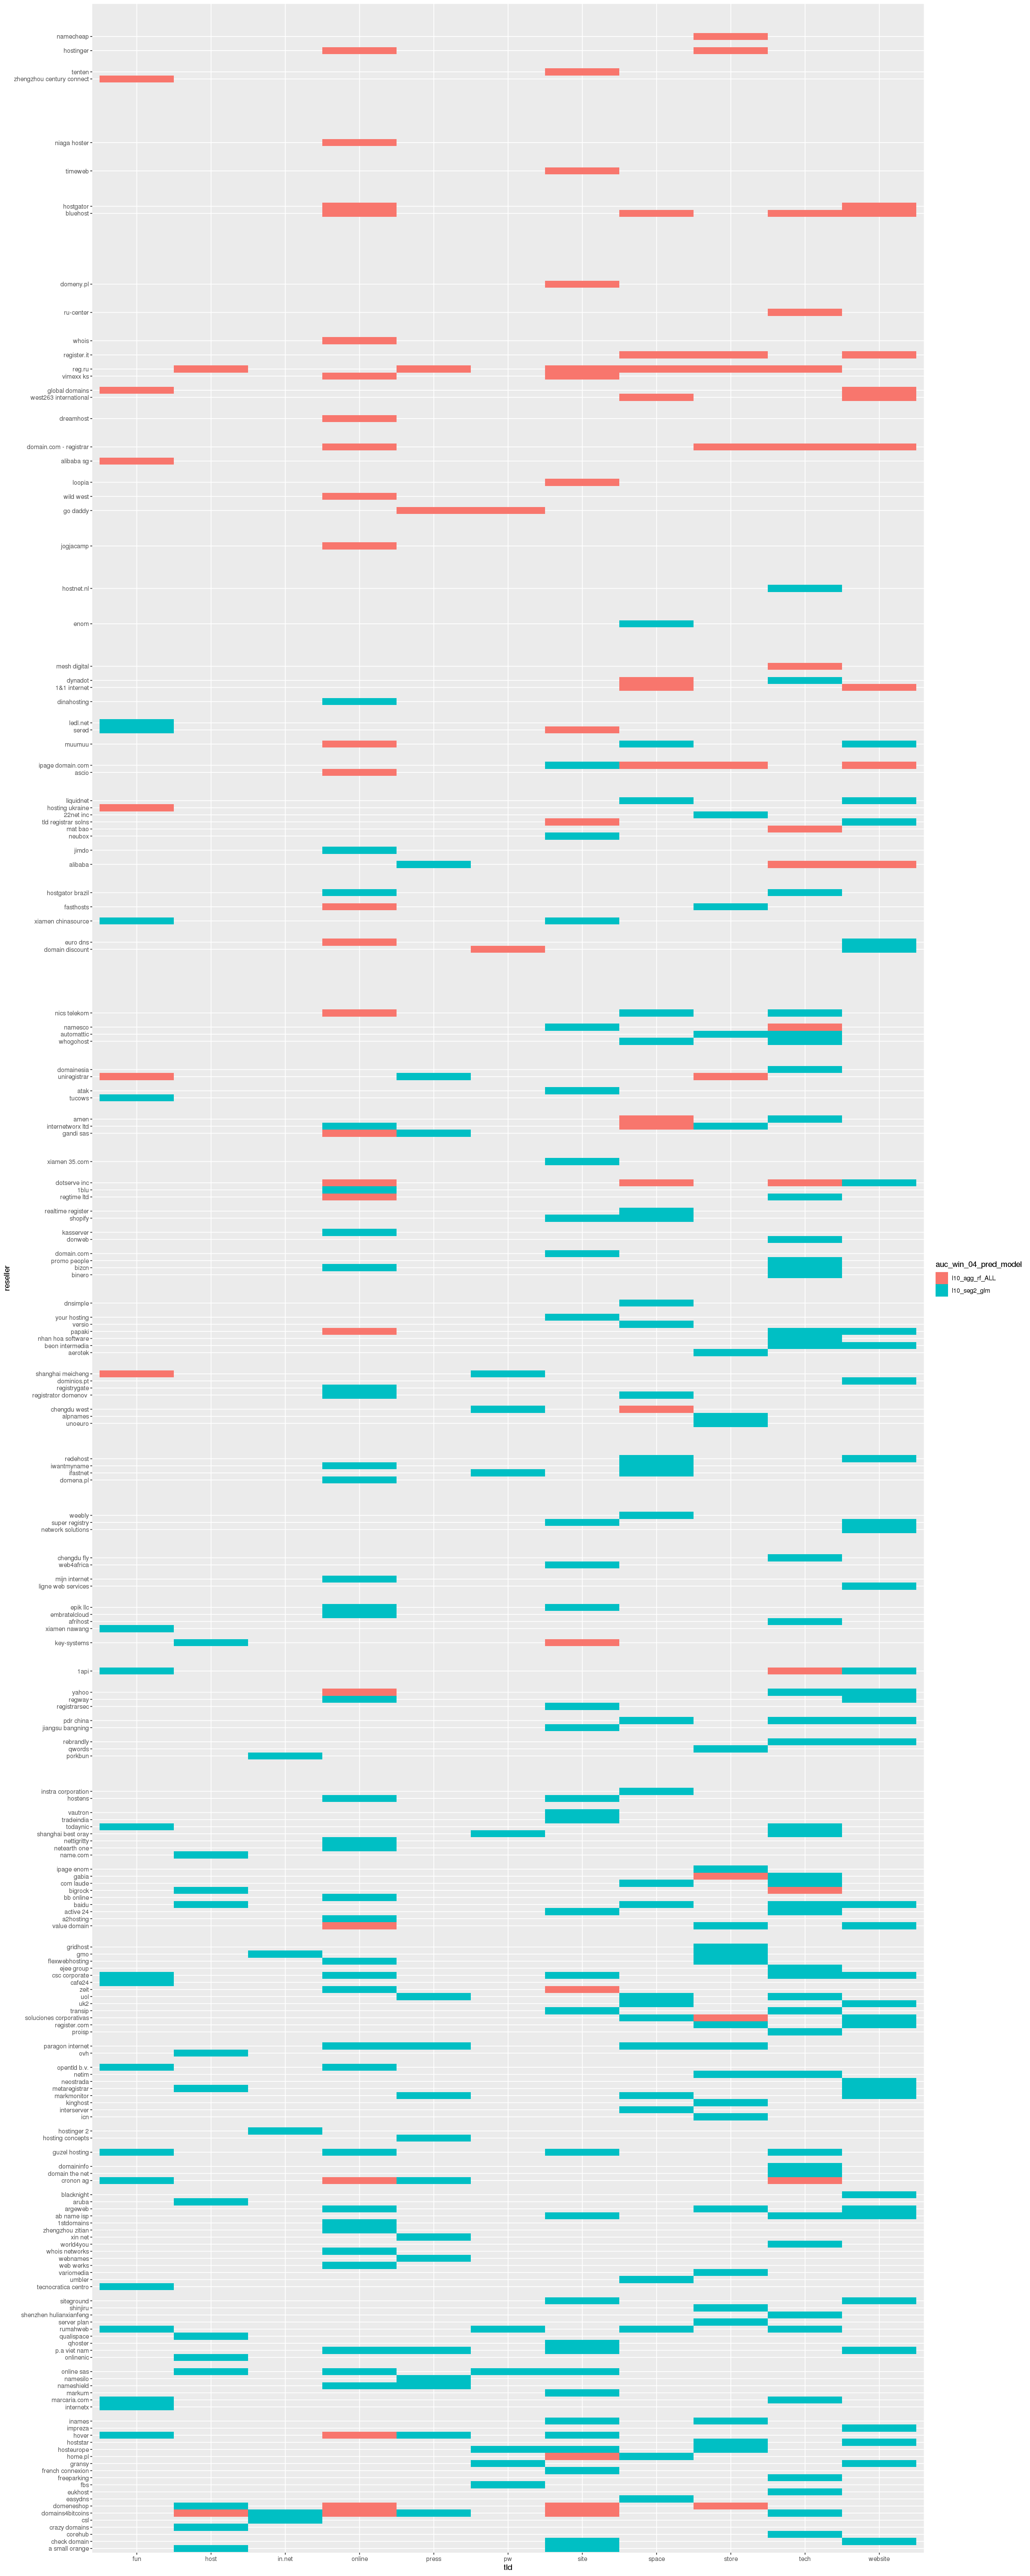

In [93]:
library(repr)
options(repr.plot.width=20, repr.plot.height=50)
ggplot(vis_df, 
       aes(tld, reseller, fill=auc_win_04_pred_model)) + 
  geom_tile() + 
  scale_y_discrete(limits=(vis_df$reseller)[order(vis_df$n)])
